## Download image dataset

In [3]:
import opendatasets as od

In [5]:
od.download("https://www.kaggle.com/datasets/spandanpatnaik09/face-mask-detectormask-not-mask-incorrect-mask")

Skipping, found downloaded files in "./face-mask-detectormask-not-mask-incorrect-mask" (use force=True to force download)


## Visualizing random samples

In [6]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [7]:
target_dir = "/content/face-mask-detectormask-not-mask-incorrect-mask/dataset"

Image shape:(316, 214, 3)
Image data type:uint8
Image max value:255
Image min value:0


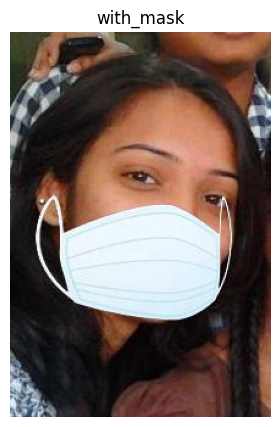

In [8]:
random_class = random.choice(os.listdir(target_dir))
random_img = random.choice(os.listdir(os.path.join(target_dir, random_class)))
image_path = os.path.join(target_dir, random_class, random_img)
img = mpimg.imread(image_path)
print(f'Image shape:{img.shape}\nImage data type:{img.dtype}\nImage max value:{img.max()}\nImage min value:{img.min()}')
plt.figure(figsize=(10, 5))
plt.title(random_class)
plt.imshow(img)
plt.axis(False)
plt.show()

## Load dataset

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [10]:
train_dataset, test_dataset = image_dataset_from_directory(target_dir,
                                                           batch_size=None,
                                                           image_size=(224,224),
                                                           seed=42,
                                                           validation_split=0.3,subset='both')

Found 2079 files belonging to 3 classes.
Using 1456 files for training.
Using 623 files for validation.


## Peprocessing images

In [11]:
import tensorflow as tf

In [12]:
def preprocess_images(image, label):
  image=image/255.
  return tf.cast(image, tf.float32), label

In [13]:
train_dataset = train_dataset.map(map_func=preprocess_images)
test_dataset = test_dataset.map(map_func=preprocess_images)

In [14]:
for image, _ in train_dataset.take(1):
  print(image.dtype)

<dtype: 'float32'>


## Setting mixed precision

In [15]:
print(f'Global policy before:{tf.keras.mixed_precision.global_policy()}')

Global policy before:<Policy "float32">


In [16]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")

In [17]:
print(f'Global policy after:{tf.keras.mixed_precision.global_policy()}')

Global policy after:<Policy "mixed_float16">


##Batching and prefetching datasets

In [18]:
train_dataset = train_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

In [19]:
test_dataset = test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

## Training a model with transfer learning

In [20]:
from tensorflow.keras import  layers

In [21]:
base_model = tf.keras.applications.ResNet101V2(include_top=False)
base_model.trainable = False #Freezing model layers

171317808/171317808 [==============================] - 1s 0us/step


In [22]:
num_classes = len(os.listdir(target_dir))
num_classes

3

In [23]:
inputs = layers.Input(shape=(224,224,3), dtype=tf.float16)
#aug_data = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = layers.Dense(num_classes)(x)
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Activation('softmax', dtype=tf.float32)(x)
model_0 = tf.keras.Model(inputs, outputs)

In [24]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet101v2 (Functional)    (None, None, None, 2048   42626560  
                             )                                   
                                                                 
 dense (Dense)               (None, 7, 7, 3)           6147      
                                                                 
 global_avg_pool_layer (Glo  (None, 3)                 0         
 balAveragePooling2D)                                            
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 
Total params: 42632707 (162.63 MB)
Trainable params: 6147 (24

In [25]:
model_0.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [26]:
model_0_history = model_0.fit(train_dataset,
                  epochs=5,
                  steps_per_epoch=len(train_dataset),
                  validation_data=test_dataset,
                  validation_steps=int(0.1 * len(test_dataset)))#validation on only 10% of the test data

Epoch 1/5
91/91 [==============================] - 24s 68ms/step - loss: 0.2658 - accuracy: 0.8984 - val_loss: 0.1076 - val_accuracy: 0.9792
Epoch 2/5
91/91 [==============================] - 8s 59ms/step - loss: 0.0434 - accuracy: 0.9897 - val_loss: 0.0699 - val_accuracy: 0.9792
Epoch 3/5
91/91 [==============================] - 7s 46ms/step - loss: 0.0237 - accuracy: 0.9959 - val_loss: 0.0808 - val_accuracy: 0.9792
Epoch 4/5
91/91 [==============================] - 7s 47ms/step - loss: 0.0137 - accuracy: 0.9986 - val_loss: 0.0661 - val_accuracy: 0.9792
Epoch 5/5
91/91 [==============================] - 8s 51ms/step - loss: 0.0094 - accuracy: 0.9993 - val_loss: 0.0826 - val_accuracy: 0.9583


In [27]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.figure(figsize=(10, 5))
  plt.subplot(1,2,1)
  plt.title('Training')
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs,acc,label='Training Accuracy')
  plt.legend()
  plt.subplot(1,2,2)
  plt.title('Validation')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.plot(epochs,val_acc, label='Validation Accuracy')
  plt.legend()
  plt.show()

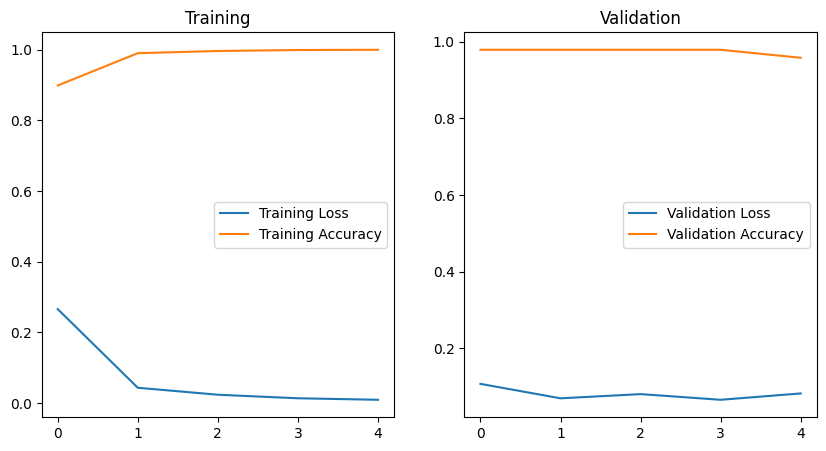

In [28]:
plot_loss_curves(model_0_history)

## Fine-tune

In [29]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(patience=3,min_lr=1e-9)
early_stop = tf.keras.callbacks.EarlyStopping(patience=1)

In [30]:
##unfreezing base_model layers
base_model.trainable=True

In [31]:
model_0.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [32]:
model_0_history_fine_tune = model_0.fit(train_dataset,
                                        epochs=10,
                                        initial_epoch=model_0_history.epoch[-1],
                                        callbacks=[early_stop,lr_reduce],
                                        steps_per_epoch=len(train_dataset),
                                        validation_data=test_dataset,
                                        validation_steps=int(0.1 * len(test_dataset)))#validation on only 10% of the test data

Epoch 5/10
91/91 [==============================] - 89s 157ms/step - loss: 0.2540 - accuracy: 0.9354 - val_loss: 0.1407 - val_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 6/10
91/91 [==============================] - 16s 140ms/step - loss: 0.0529 - accuracy: 0.9856 - val_loss: 0.1288 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 7/10
91/91 [==============================] - 16s 138ms/step - loss: 0.1052 - accuracy: 0.9670 - val_loss: 0.0389 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 8/10
91/91 [==============================] - 16s 141ms/step - loss: 0.0358 - accuracy: 0.9924 - val_loss: 0.0247 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 9/10
91/91 [==============================] - 15s 137ms/step - loss: 0.0066 - accuracy: 0.9986 - val_loss: 0.0233 - val_accuracy: 0.9792 - lr: 1.0000e-04
Epoch 10/10
91/91 [==============================] - 16s 136ms/step - loss: 5.3724e-04 - accuracy: 1.0000 - val_loss: 0.0567 - val_accuracy: 0.9792 - lr: 1.0000e-04


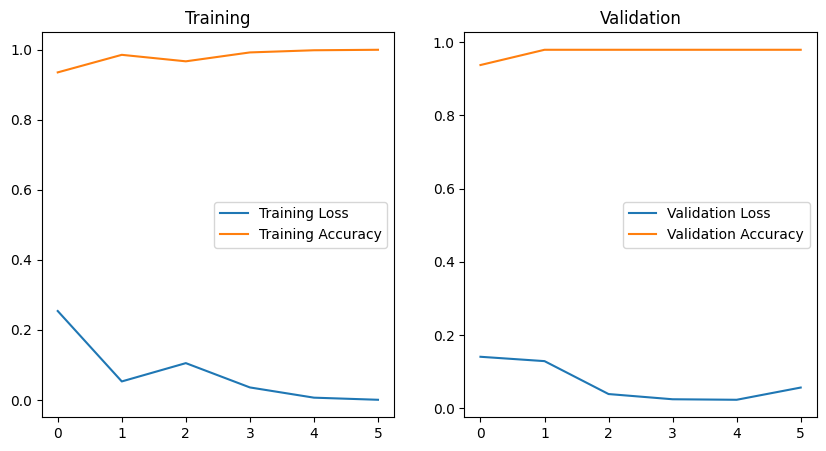

In [33]:
plot_loss_curves(model_0_history_fine_tune)

In [34]:
## making some predictions
y_pred_probs = model_0.predict(test_dataset)
y_pred = tf.argmax(y_pred_probs, axis=1)

39/39 [==============================] - 5s 73ms/step


In [35]:
## Evaluating the model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [36]:
import numpy as np
y_true = []
for _,label in test_dataset.unbatch():
  y_true.append(label)
y_true = np.array(y_true)

In [37]:
y_true

array([0, 1, 2, 2, 1, 2, 2, 0, 1, 1, 2, 0, 0, 0, 2, 1, 0, 2, 0, 1, 2, 2,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 2, 2, 2, 0, 2, 2, 0, 1, 0, 1, 2, 0, 0,
       2, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0,
       1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 0, 2, 1, 2, 0, 1, 2, 2, 1, 0, 2,
       1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 0, 0, 2, 2, 2, 1, 1, 0, 2, 1, 2, 1,
       1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2,
       0, 2, 2, 0, 1, 1, 1, 2, 0, 1, 2, 0, 0, 1, 1, 0, 0, 2, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 0, 1, 0, 1, 2, 1, 1, 0,
       2, 1, 1, 2, 0, 0, 1, 1, 1, 0, 0, 2, 0, 2, 0, 0, 1, 1, 2, 1, 1, 0,
       0, 1, 1, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 1, 0, 0, 1, 1, 0, 2,
       1, 2, 0, 2, 0, 2, 1, 2, 2, 1, 2, 0, 2, 1, 2, 0, 0, 2, 0, 2, 1, 0,
       0, 2, 1, 1, 2, 0, 2, 2, 0, 2, 0, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 0,
       2, 1, 1, 1, 2, 1, 1, 0, 2, 2, 0, 1, 1, 2, 0, 2, 2, 2, 0, 2, 2, 1,
       0, 0, 0, 1, 0, 2, 2, 1, 2, 0, 1, 2, 1, 0, 2,

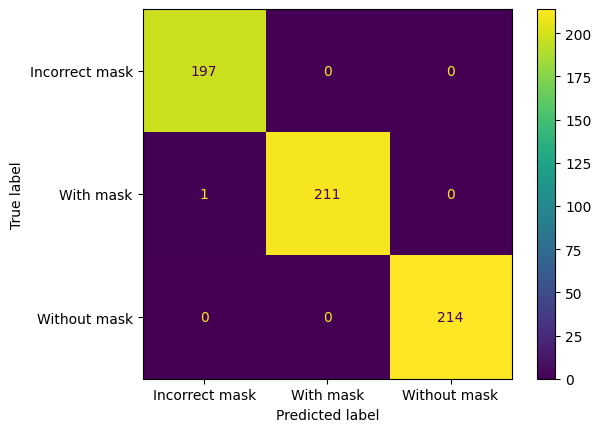

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       197
           1       1.00      1.00      1.00       212
           2       1.00      1.00      1.00       214

    accuracy                           1.00       623
   macro avg       1.00      1.00      1.00       623
weighted avg       1.00      1.00      1.00       623



In [38]:
cm  = confusion_matrix(y_true, tf.squeeze(y_pred))
disp = ConfusionMatrixDisplay(cm,display_labels=['Incorrect mask','With mask','Without mask'])
disp.plot()
plt.show()
print(classification_report(y_true, tf.squeeze(y_pred)))